In [1]:
from pathlib import Path
dataset_root = Path("/Vol1/dbstore/datasets/e.zakharov/VoxCeleb1/imgs/train")

In [51]:
import cv2
import dlib
cv2.setNumThreads(1)

import torch
from torch.utils.data import Dataset, DataLoader

class VoxCeleb1Crops(Dataset):
    def __init__(self, root):
        self.root = root
        
        self.all_paths = []
        for identity in dataset_root.iterdir():
            for video in identity.iterdir():
                self.all_paths += list(video.iterdir())[::4]
                break
        
        self.face_detector = dlib.get_frontal_face_detector()

    def __len__(self):
        return len(self.all_paths)
    
    def __getitem__(self, i):
        img = cv2.imread(str(self.all_paths[i]))
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB, dst=img)
        bboxes = self.face_detector(img)
        
        if bboxes:
            bbox = bboxes[0]
            l, t, r, b = bbox.left(), bbox.top(), bbox.right(), bbox.bottom()
        else:
            l, t, r, b = (0, 0,) + img.shape[:2]

        # center, relative to (t,l) in terms of crop size
        center_x, center_y = img.shape[1] * 0.5, img.shape[0] * 0.5
        center_x_rel = (center_x - l) / (r - l)
        center_y_rel = (center_y - t) / (b - t)
        # in terms of crop size (assume it's square)
        image_size_rel = img.shape[0] / (b - t)
        
        return torch.tensor([center_x_rel, center_y_rel, image_size_rel], dtype=torch.float32)

In [52]:
dataset = VoxCeleb1Crops(dataset_root)
dataloader = DataLoader(dataset, num_workers=10, batch_size=100)

In [53]:
from tqdm import tqdm_notebook as tqdm

table = torch.empty(len(dataset), 3)
total = 0

for batch in tqdm(dataloader):
    table[total:total+len(batch)] = batch
    total += len(batch)

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
table.median(0)[0]

tensor([0.5000, 0.5056, 1.6720])

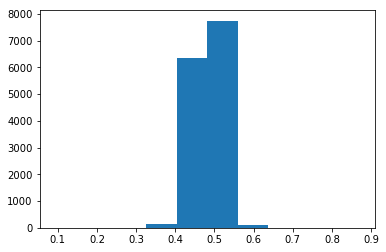

In [56]:
plt.hist(table[:, 0]);

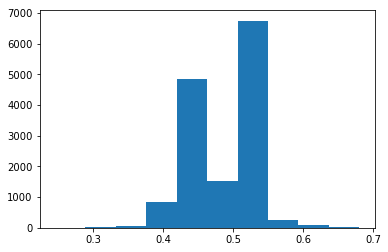

In [57]:
plt.hist(table[:, 1]);

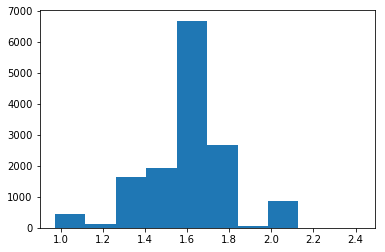

In [58]:
plt.hist(table[:, 2]);